Tutorial 4: Aggregator
===========================
In chapter 1. we used used the `Aggregator` to load and inspect the `Samples` and fits of a model-fit.

In this tutorial, we'll look at how the phase API and the template source code makes it easy to use the `Aggregator`
to inspect, interpret and plot the results of the model-fit in ways that were not possible in chapter 1.

In [1]:
%matplotlib inline
from pyprojroot import here

workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
from autoconf import conf


conf.instance.push(
    new_path=path.join(workspace_path, "howtofit", "chapter_phase_api", "src", "config")
)

import autofit as af
import src as htf

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


To load these results with the `Aggregator`, we again point it to the path of the results we want it to inspect, with
our path straight to the `Aggregator` results ensuring we don't need to filter our `Aggregator` in this tutorial.

In [2]:
agg = af.Aggregator(
    directory=path.join("output", "howtofit", "chapter_phase_api", "phase_t1")
)

Aggregator loading phases... could take some time.

 A total of 1 phases and results were found.


We can again use the `Aggregator` to load a generator of every fit`s dataset, by changing the `output` attribute to 
the `dataset` attribute at the end of the aggregator.

Note how in chapter 1 this attribute corresponded to that `data` and `noise_map` seprately, where the chapter 2 template 
projects simply outputs the `Dataset` object. For a realistic model-fitting project the object containing the data
could well have many attributes, highlighting the benefit for the `Aggregator` there is by containing it all in one 
class.

In [3]:
dataset_gen = agg.values("dataset")
print("Datasets:")
print(list(dataset_gen), "\n")

Datasets:



It is here the object-oriented design of our `plot.py` module comes into its own. We have the `Dataset` objects loaded, 
meaning we can easily plot each `Dataset` using the `dataset_plot.py` module.

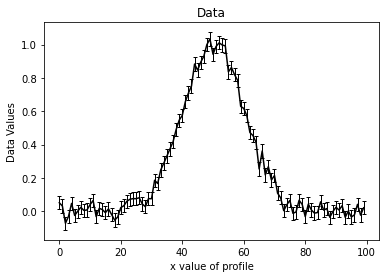

<Figure size 432x288 with 0 Axes>

In [4]:
for dataset in agg.values("dataset"):
    htf.plot.Dataset.data(dataset=dataset)

The `info` dictionary we input into the `Phase` is also available.

In [5]:
for info in agg.values("info"):
    print(info)

{'date_of_observation': '01-02-18', 'exposure_time': 1000.0}


We're going to refit each `Dataset` with the `max_log_likelihood_instance` of each model-fit. To do this, we'll need 
each `Phase`'s `Dataset`.

(If you are unsure what the `zip` is doing below, it essentially combines the `dataset_gen` and `settings_gen` into 
one list such that we can iterate over all three simultaneously to create each trimmed `Dataset`).

The `Dataset` may have been altered by the `data_trim_left` and `data_trim_right` `SettingsPhase`. We can 
load the `SettingsPhase` via the `Aggregator` to use these settings when we create the `Dataset`.

In [6]:
dataset_gen = agg.values("dataset")
settings_gen = agg.values("settings")

datasets = [
    dataset.trimmed_dataset_from_settings(settings=settings.settings_dataset)
    for dataset, settings in zip(dataset_gen, settings_gen)
]

Of course, we should actually be setting up the `Dataset`'s using generators.

In [7]:


def dataset_from_agg_obj(agg_obj):

    dataset = agg_obj.dataset
    settings = agg_obj.settings

    return dataset.trimmed_dataset_from_settings(settings=settings.settings_dataset)


To use this function as a generator using the `Aggregator`, we again apply the `Aggregator`'s `map` function.

In [8]:
dataset_gen = agg.map(func=dataset_from_agg_obj)
print(list(dataset_gen))

Lets get the `max_log_likelihood_instance`s, as we did in chapter 1.

In [9]:
instances = [samps.max_log_likelihood_instance for samps in agg.values("samples")]

Okay, we want to inspect the fit of each `max_log_likelihood_instance`. To do this, we reperform each fit.

First, we need to create the `model_data` of every `max_log_likelihood_instance`. Lets begin by creating a list 
of profiles of every phase.

In [10]:
profiles = [instance.profiles for instance in instances]

We can use these to create the `model_data` of each set of profiles (which in this case is just 1 `Gaussian`, but had
we included more profiles in the model would consist of multiple `Gaussian`s / `Exponential`s.).

In [11]:
model_datas = [
    profile.gaussian.profile_from_xvalues(xvalues=dataset.xvalues)
    for profile, dataset in zip(profiles, agg.values("dataset"))
]

We can combine the `Dataset`s and `model_data`s in a `Fit` object to create the maximum likelihood fit of each phase!

In [12]:
fits = [
    htf.FitDataset(dataset=dataset, model_data=model_data)
    for dataset, model_data in zip(datasets, model_datas)
]

We can now plot different components of the `Fit` (again benefiting from how we set up the `fit_plots.py` module)!

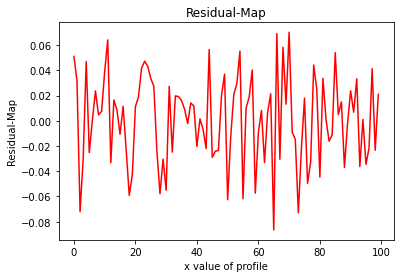

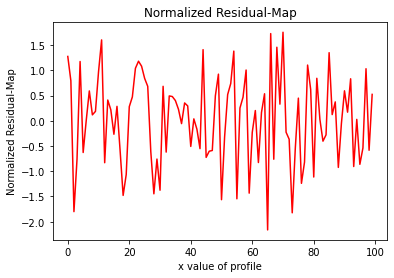

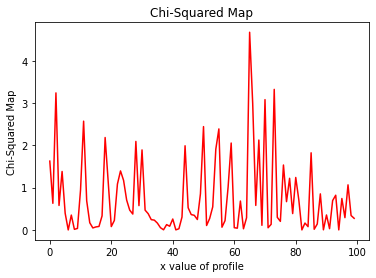

<Figure size 432x288 with 0 Axes>

In [13]:
for fit in fits:
    htf.plot.FitDataset.residual_map(fit=fit)
    htf.plot.FitDataset.normalized_residual_map(fit=fit)
    htf.plot.FitDataset.chi_squared_map(fit=fit)

Again, the code above does not use generators and could prove memory intensive for large datasets. Below is how we 
would perform the above task with generator functions, using the `dataset_gen` above for the `Dataset`.

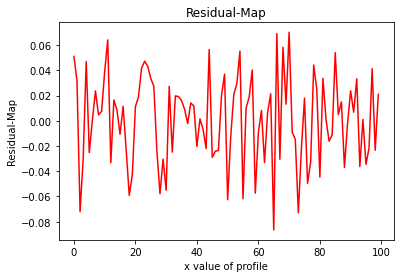

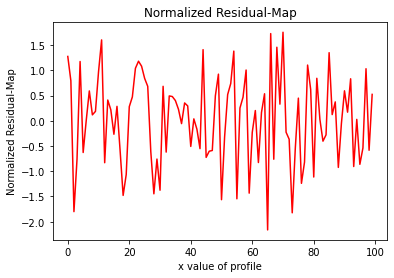

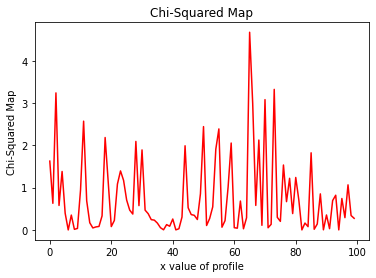

<Figure size 432x288 with 0 Axes>

In [14]:


def model_data_from_agg_obj(agg_obj):

    xvalues = agg_obj.dataset.xvalues
    instance = agg_obj.samples.max_log_likelihood_instance
    profiles = instance.profiles

    return sum([profile.profile_from_xvalues(xvalues=xvalues) for profile in profiles])


def fit_from_agg_obj(agg_obj):

    dataset = dataset_from_agg_obj(agg_obj=agg_obj)
    model_data = model_data_from_agg_obj(agg_obj=agg_obj)

    return htf.FitDataset(dataset=dataset, model_data=model_data)


fit_gen = agg.map(func=fit_from_agg_obj)

for fit in fit_gen:
    htf.plot.FitDataset.residual_map(fit=fit)
    htf.plot.FitDataset.normalized_residual_map(fit=fit)
    htf.plot.FitDataset.chi_squared_map(fit=fit)

Setting up the above objects (the `dataset's, `model data`s, `fit`s) was a bit of work. It wasn`t too many 
lines of code, but for something our users will want to do many times it`d be nice to have a short cut to setting them 
up, right?

In the source code module `aggregator.py` we've set up exactly such a short-cut. This module simply contains the 
generator functions above such that the generator can be created by passing the `Aggregator`. This provides us with 
convenience methods for quickly creating the `Dataset`, `model_data` and `Fit`'s using a single line of code:

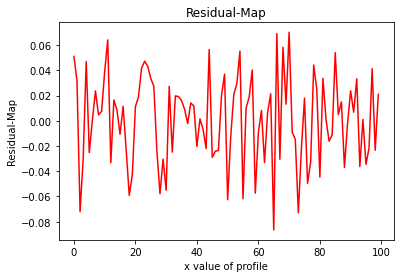

<Figure size 432x288 with 0 Axes>

In [15]:
dataset_gen = htf.agg.dataset_generator_from_aggregator(aggregator=agg)
model_data_gen = htf.agg.model_data_generator_from_aggregator(aggregator=agg)
fit_gen = htf.agg.fit_generator_from_aggregator(aggregator=agg)

for fit in fit_gen:

    htf.plot.FitDataset.residual_map(fit=fit)

The methods in `aggregator.py` actually allow us to go one step further: they all us to create the `Dataset` and
`Fit` objects using an input `SettingsDataset`. This means we can fit a `Dataset` with a `Phase` and then see how
the model-fits change if we customize the `Dataset` in different ways.

Below, we create and plot a `Fit` where the `Dataset` is trimmed from the left and right.

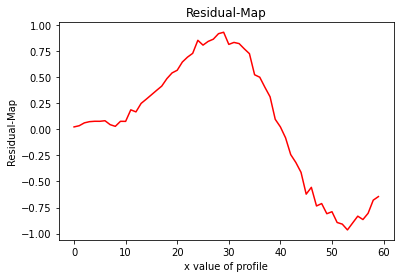

<Figure size 432x288 with 0 Axes>

In [16]:
settings_dataset = htf.SettingsDataset(data_trim_left=20, data_trim_right=20)

fit_gen = htf.agg.fit_generator_from_aggregator(
    aggregator=agg, settings_dataset=settings_dataset
)

htf.plot.FitDataset.residual_map(fit=list(fit_gen)[0])

For your model-fitting project, you'll need to update the `aggregator.py` module in the same way. This is why we have 
emphasised the object-oriented design of our model-fitting project throughout. This design makes it very easy to 
inspect results via the `Aggregator` later on!